In [15]:
import json
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import stats
from scipy.optimize import minimize_scalar

In [16]:
font = {'size'   : 16}

mpl.rc('font', **font)

# plt.rcParams['text.usetex'] = True
# pgf_with_rc_fonts = {"pgf.texsystem": "pdflatex"}
# plt.rcParams.update(pgf_with_rc_fonts)
# plt.rcParams['text.latex.preamble'] = [r'\usepackage{tgheros}',
#                                        r'\usepackage{sansmath}',
#                                        r'\sansmath',
#                                        r'\usepackage{siunitx}',
#                                        r'\sisetup{detect-all}']
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 'large'

In [17]:
with open('data/angle_dimer_fits_121120.json', 'r') as f:
    data = json.load(f)
    
df = pd.DataFrame(data)

In [18]:
n_p = df.n_p
a_p = df.a_p

theta = df.theta


d_fit = df['a_p^*']*2
n_fit = df['n_p^*']

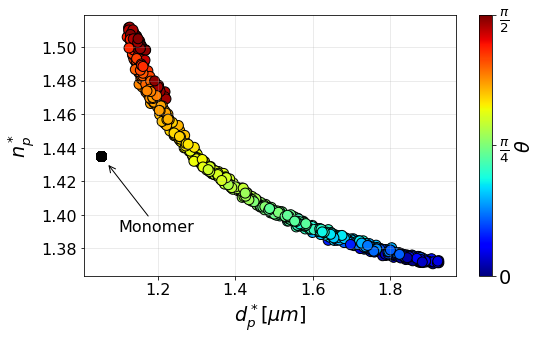

In [19]:
fig, ax1 = plt.subplots(figsize=(8,5))

color = 'tab:red'
ax1.set_xlabel('$d_p^* [\mu m]$')
ax1.set_ylabel('$n_p^*$')
ax1.scatter(2*a_p, n_p, color='black', s=100)
ax1.annotate('Monomer', xy = (2*a_p[0]*1.015, n_p[0]*.997), xytext = (1.1, 1.39), arrowprops={'arrowstyle': '->'})

ct = ax1.scatter(d_fit, n_fit, s=100, c = theta, cmap='jet', edgecolor='black', vmin=0, vmax=np.pi/2)
ax1.tick_params(axis='y')
cb = fig.colorbar(ct, ax=ax1, ticks=[0, np.pi/4, np.pi/2])
cb.set_label(r'$\theta$')
cb.ax.set_yticklabels(['0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$'])
cb.ax.tick_params(labelsize='large')

ax1.grid(alpha=0.3)


fig.tight_layout()
plt.show()

fig.savefig('dimers_theta_fits03.png')

## Fit parametric curve to sigmoids

Note: here I do not use $\theta_1 = \theta_2$ (yet?)

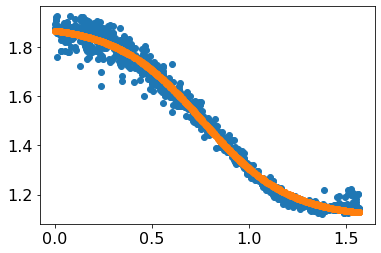

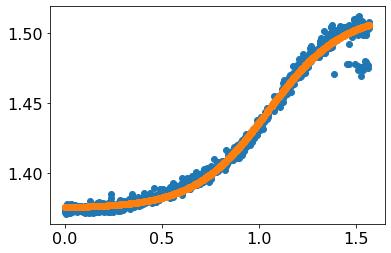

In [20]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

p0 = [max(d_fit), np.median(theta),1,min(d_fit)] # this is an mandatory initial guess

popt_d, pcov = curve_fit(sigmoid,theta, d_fit,p0, method='dogbox')
d_model = sigmoid(theta, *popt_d)

plt.scatter(theta, d_fit)
plt.scatter(theta, d_model)
plt.show()

popt_n, pcov = curve_fit(sigmoid,theta, n_fit,p0, method='dogbox')
n_model = sigmoid(theta, *popt_n)

plt.scatter(theta, n_fit)
plt.scatter(theta, n_model)
plt.show()

## Plot parametric curve

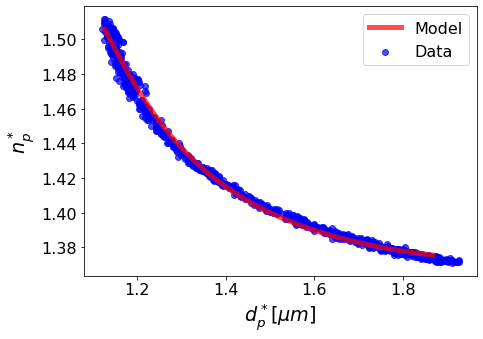

In [21]:
fig, ax = plt.subplots(figsize=(7,5))

d_model, n_model = zip(*sorted(zip(d_model, n_model)))

ax.scatter(d_fit, n_fit, c='b', label='Data', alpha=0.7)
ax.plot(d_model, n_model, c='r', label='Model', alpha=0.7, linewidth=5)
ax.legend()
ax.set_xlabel('$d_p^* [\mu m]$')
ax.set_ylabel('$n_p^*$')
fig.tight_layout()
#fig.savefig('parameterized_curve.png')

## For each data point, obtain closest value for $\theta$ based on our model

Minimize distance from the curve

Text(0, 0.5, '$\\rho(\\theta)$')

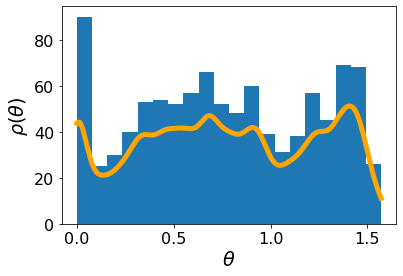

In [22]:
def makedistance(point):
    d0, n0 = point
    def distance(theta):
        dist = np.sqrt((d0 - sigmoid(theta, *popt_d))**2 + (n0 - sigmoid(theta, *popt_n))**2)
        return dist
    return distance

theta_fit = []
for i in range(len(d_fit)):
    point = (d_fit[i], n_fit[i])
    distance = makedistance(point)
    res = minimize_scalar(distance, bounds=(0, np.pi/2), method='bounded')
    theta_fit.append(res.x)

# plt.scatter(d_fit, n_fit)
# plt.scatter(sigmoid(theta_fit, *popt_d), sigmoid(theta_fit, *popt_n))
# plt.show()
fig, ax = plt.subplots()
ax.hist(theta_fit, bins=20)
kernel_sim = stats.gaussian_kde(theta_fit, bw_method=0.1)
rho_sim = kernel_sim(np.sort(theta_fit))
ax.plot(np.sort(theta_fit), 60*rho_sim, color='orange', linewidth=5, label='KDE')
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\rho(\theta)$')
#fig.savefig('rho_theta_sim.png')

## Load experimental data

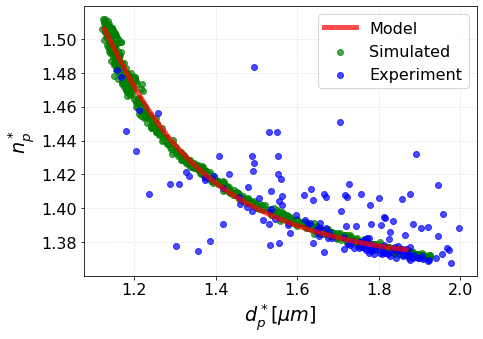

In [23]:
exp_data = pd.read_csv('data/cheong_separated02.csv')

exp_dimers = exp_data[exp_data['label'] == 'dimer']
exp_mono = exp_data[exp_data['label'] == 'monomer']
d_ex = exp_dimers.d_p
n_ex = exp_dimers.n_p
z_ex = exp_dimers.z_p

fig, ax = plt.subplots(figsize=(7,5))

#ax.scatter(exp_mono.d_p, exp_mono.n_p)
#ax.scatter(a_p*2, n_p, color='yellow')
ax.scatter(d_fit, n_fit, c='g', label='Simulated', alpha=0.7)
ax.plot(d_model, n_model, c='r', label='Model', alpha=0.7, linewidth=5)
ax.scatter(d_ex, n_ex, c='b', label='Experiment', alpha=0.7)
ax.legend()
ax.set_xlabel('$d_p^* [\mu m]$')
ax.set_ylabel('$n_p^*$')
ax.grid(alpha=0.3, linestyle='dashed')
fig.tight_layout()
fig.savefig('figures/angle_compare02.png')

## Obtain experimental theta values using the same model

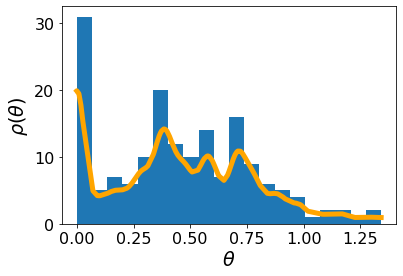

In [24]:
n_ex = np.array(n_ex)
d_ex = np.array(d_ex)

theta_ex = []
for i in range(len(d_ex)):
    point = (d_ex[i], n_ex[i])
    distance = makedistance(point)
    res = minimize_scalar(distance, bounds=(0, np.pi/2), method='bounded')
    theta_ex.append(res.x)
    
# plt.scatter(d_ex, n_ex)
# plt.scatter(sigmoid(theta_ex, *popt_d), sigmoid(theta_ex, *popt_n))
# plt.show()
fig, ax = plt.subplots()
ax.hist(theta_ex, bins=20)
kernel_ex = stats.gaussian_kde(theta_ex, bw_method=0.1)
rho_ex = kernel_ex(np.sort(theta_ex))
ax.plot(np.sort(theta_ex), 9*rho_ex, color='orange', linewidth=5, label='KDE')
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\rho(\theta)$')
fig.savefig('rho_theta_ex.png')

In [25]:
def mason(theta, r=2):
    p = r/(2* np.pi * (r**2 * np.sin(theta)**2 + np.cos(theta)**2))
    return p

## Plot both angular densities

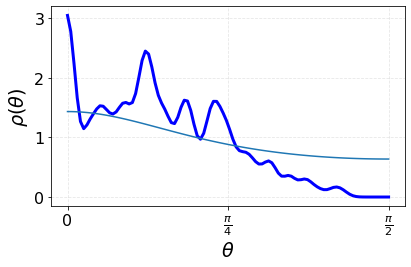

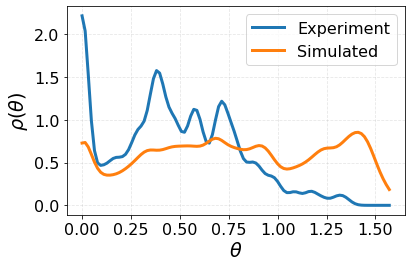

In [26]:
theta_run = np.linspace(0, np.pi/2, num=100)
rho_sim = kernel_sim(theta_run)
rho_ex = kernel_ex(theta_run)


rho_diff = [kernel_ex(x)/kernel_sim(x) for x in theta_run]

fig, ax = plt.subplots()
ax.plot(theta_run, rho_diff, linewidth=3, c='b')
ax.plot(theta_run, 6*mason(theta_run, r=1.5))
ax.set_xticks([0, np.pi/4, np.pi/2])
ax.set_xticklabels(['0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$'])
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\rho(\theta)$')
fig.tight_layout()
ax.grid(alpha=0.3, linestyle='dashed')
plt.show()
#fig.savefig('figures/rho_divided.png')

fig, ax = plt.subplots()
ax.plot(theta_run, rho_ex, linewidth=3, label='Experiment')
ax.plot(theta_run, rho_sim, linewidth=3, label='Simulated')
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\rho(\theta)$')
ax.legend()
fig.tight_layout()
ax.grid(alpha=0.3, linestyle='dashed')
#fig.savefig('figures/rho_theta_compare02.png')

In [27]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

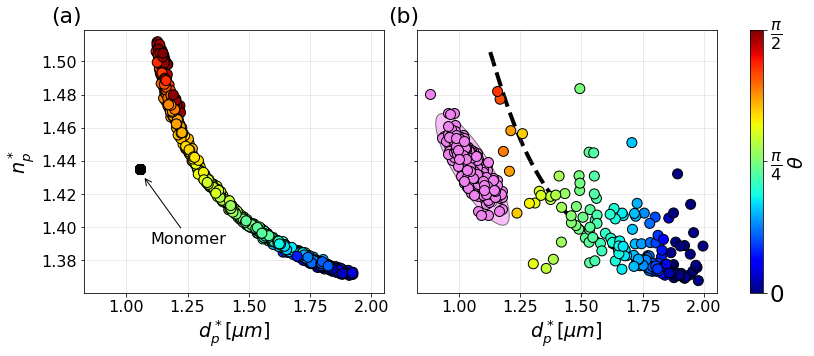

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(13,5), sharey=True, sharex=True
                                    , gridspec_kw={'width_ratios': [5,5,1], 'wspace': 0.15, 'hspace': 0})

color = 'tab:red'
ax1.set_xlabel('$d_p^* [\mu m]$')
ax1.set_ylabel('$n_p^*$')
ax1.scatter(2*a_p, n_p, color='black', s=100)
ax1.annotate('Monomer', xy = (2*a_p[0]*1.015, n_p[0]*.997), xytext = (1.1, 1.39), arrowprops={'arrowstyle': '->'})
ax1.plot(d_model, n_model, c='k', linewidth=4, zorder=1)
ct = ax1.scatter(d_fit, n_fit, s=100, c = theta, cmap='jet', edgecolor='black', vmin=0, vmax=np.pi/2, zorder=2)
ax1.tick_params(axis='y')
ax1.grid(alpha=0.3)

ax2.set_xlabel('$d_p^* [\mu m]$')
ax2.plot(d_model, n_model, c='k', linewidth=4, zorder=1, linestyle='dashed')
xy = np.vstack([exp_mono.d_p, exp_mono.n_p])
rho_mono = stats.gaussian_kde(xy)(xy)
fcolor = 'violet'
ax2.scatter(exp_mono.d_p, exp_mono.n_p, s=100, c=fcolor, zorder=5, edgecolor='black')
confidence_ellipse(exp_mono.d_p, exp_mono.n_p, ax2, edgecolor='black',facecolor=fcolor, alpha=0.5, n_std=3, zorder=1)
confidence_ellipse(exp_mono.d_p, exp_mono.n_p, ax2, edgecolor='black',facecolor=fcolor, alpha=0.5, n_std=2, zorder=2)
confidence_ellipse(exp_mono.d_p, exp_mono.n_p, ax2, edgecolor='black', facecolor=fcolor, alpha=0.5, n_std=1, zorder=3)
ax2.scatter(d_ex, n_ex, s=100, c= theta_ex, cmap='jet', edgecolor='black', vmin=0, vmax=np.pi/2, zorder=2)
# ax2.annotate('Monomer', xy = (2*a_p[0]*1.015, n_p[0]*.997), xytext = (1.1, 1.39), arrowprops={'arrowstyle': '->'})
ax2.grid(alpha=0.3)

ax3.axis('off')
cb = fig.colorbar(ct, ax=ax3, ticks=[0, np.pi/4, np.pi/2], fraction=1)
cb.set_label(r'$\theta$')
cb.ax.set_yticklabels(['0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$'])
cb.ax.tick_params(labelsize='x-large')

fig.text(0.09,0.9,'(a)', fontdict={'fontsize':22})
fig.text(0.45,0.9,'(b)', fontdict={'fontsize':22})
#fig.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15)
#fig.savefig('figures/angle_compare06.png')

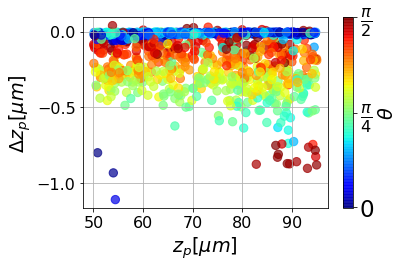

In [37]:
z_fit = df['z_p^*']*0.120

zdiff = z_fit - df.z_p

fig, ax = plt.subplots()
scatter = ax.scatter(df.z_p, zdiff, s=70, c=df.theta, cmap='jet', alpha=0.7)
#ax.plot(df.z_p, df.z_p, c='r')
cb = fig.colorbar(scatter, ax=ax, ticks=[0.01, np.pi/4, np.pi/2-0.001])
cb.ax.tick_params(labelsize='x-large')
cb.set_label(r'$\theta$')
cb.ax.set_yticklabels(['0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$'])
ax.set_xlabel(r'$z_p [\mu m]$')
ax.set_ylabel(r'$\Delta z_p [\mu m]$')
ax.grid()
fig.tight_layout()
fig.savefig('z_error02.svg')

In [19]:
zdiff = df.z_p - z_fit
zrmse = np.sqrt((np.sum([x**2 for x in zdiff]))/len(zdiff))

print(zrmse)

0.2556399487712625


In [21]:
0.25/0.12

2.0833333333333335